# BMC_Red Volume Prediction: EfficientNetB0 + ES(1+1) Optimization

This notebook uses **EfficientNetB0** with **PyTorch** and **ES(1+1) hyperparameter optimization** to predict measuring cup volume from the **BMC_Red** dataset.

## Dataset: BMC_Red
- **Structure**: Volume folders with `Bxxx_BV` (bottom view) and `Bxxx_FV` (front view) subfolders
- **Training**: ~821 images across 22 volume classes (100-610 mL)
- **Testing**: ~107 images across 11 volume classes
- **Image format**: JPG

## Algorithm: ES(1+1) with 1/5 Success Rule
- **(1+1)**: 1 parent generates 1 offspring, better one survives
- **1/5 Rule**: If success rate > 20%, increase step sizes (explore); otherwise decrease (exploit)

## Key Features:
1. **Proper train/validation split** - Avoids data leakage
2. **No early termination** - ES runs full generations to explore
3. **Baseline parameters as ES starting point**
4. **Wide hyperparameter search ranges**

In [1]:
# ============================================================
# CELL 1: IMPORTS AND SETUP
# ============================================================
import os
import time
import numpy as np
import copy
import gc
import json
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, models

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# Start timing
START_TIME = time.time()

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f"Using device: {device}")

PyTorch version: 2.1.0+cu121
CUDA available: True
GPU: NVIDIA A100 80GB PCIe
Using device: cuda


In [2]:
# ============================================================
# CELL 2: CONFIGURATION
# ============================================================

# Dataset paths - BMC_Red dataset
TRAIN_BASE = "/data1/Siri/MeasuringCup/BMC_Red/Red_Training"
TEST_BASE = "/data1/Siri/MeasuringCup/BMC_Red/Red_Testing"
OUTPUT_DIR = "/data1/Siri/MeasuringCup/BMC_Red/Red_code"

# Create output directory if needed
os.makedirs(OUTPUT_DIR, exist_ok=True)

MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, "efficientnet_red_baseline.pth")
ES_MODEL_SAVE_PATH = os.path.join(OUTPUT_DIR, "efficientnet_red_es_best.pth")
ES_RESULTS_PATH = os.path.join(OUTPUT_DIR, "es_optimization_results.json")

# Image settings
IMG_SIZE = 224

# Baseline training settings
BASELINE_EPOCHS = 50
BASELINE_PATIENCE = 15

# Validation split ratio (from training data)
VAL_SPLIT = 0.15

print("Configuration:")
print(f"  Dataset: BMC_Red")
print(f"  Image Size: {IMG_SIZE}x{IMG_SIZE}")
print(f"  Validation Split: {VAL_SPLIT*100:.0f}%")
print(f"  Baseline Epochs: {BASELINE_EPOCHS}")
print(f"  Output Directory: {OUTPUT_DIR}")

Configuration:
  Dataset: BMC_Red
  Image Size: 224x224
  Validation Split: 15%
  Baseline Epochs: 50
  Output Directory: /data1/Siri/MeasuringCup/BMC_Red/Red_code


In [3]:
# ============================================================
# CELL 3: DATA COLLECTION FUNCTIONS
# ============================================================

def collect_images_red(base_folder):
    """
    Collect images from BMC_Red folder structure.
    
    BMC_Red structure (similar to BMC_NewResized):
    - Volume folders (100, 105, 150, etc.)
    - Each volume folder has Bxxx_BV and Bxxx_FV subfolders
    - Images are inside these subfolders
    """
    X_paths = []
    Y = []
    
    for volume_folder in sorted(os.listdir(base_folder)):
        # Skip non-numeric folders (like CSV files)
        if not volume_folder.isdigit():
            continue
        
        vol_path = os.path.join(base_folder, volume_folder)
        if not os.path.isdir(vol_path):
            continue
        
        # Iterate through Bxxx_FV and Bxxx_BV subfolders
        for sub in sorted(os.listdir(vol_path)):
            sub_path = os.path.join(vol_path, sub)
            if not os.path.isdir(sub_path):
                continue
            
            for img_file in sorted(os.listdir(sub_path)):
                if img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    X_paths.append(os.path.join(sub_path, img_file))
                    Y.append(int(volume_folder))
    
    return X_paths, np.array(Y, dtype=np.float32)


def load_images(paths, target_size=(224, 224)):
    """Load images and normalize to [0,1]."""
    X = []
    for p in paths:
        img = Image.open(p).convert('RGB')
        img = img.resize(target_size, Image.BILINEAR)
        img_array = np.array(img, dtype=np.float32) / 255.0
        X.append(img_array)
    return np.array(X, dtype=np.float32)


print("Data collection functions defined.")
print("  - collect_images_red(): For BMC_Red with BV/FV subfolders")
print("  - load_images(): Load and normalize images to [0,1]")

Data collection functions defined.
  - collect_images_red(): For BMC_Red with BV/FV subfolders
  - load_images(): Load and normalize images to [0,1]


In [4]:
# ============================================================
# CELL 4: LOAD AND SPLIT DATA
# ============================================================
print("="*60)
print("LOADING BMC_Red DATA")
print("="*60)

# Collect paths and labels
train_paths, Y_train_full = collect_images_red(TRAIN_BASE)
test_paths, Y_test = collect_images_red(TEST_BASE)

print(f"\nTotal training images: {len(train_paths)}")
print(f"Testing images: {len(test_paths)}")
print(f"Volume range: {Y_train_full.min():.0f} - {Y_train_full.max():.0f} mL")

# Load all images
print("\nLoading training images...")
X_train_full = load_images(train_paths)
print("Loading test images...")
X_test = load_images(test_paths)

# Split training data into train and validation
# This is CRITICAL - we don't use test set during hyperparameter optimization
print(f"\nSplitting training data ({VAL_SPLIT*100:.0f}% for validation)...")
X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_full, Y_train_full, 
    test_size=VAL_SPLIT, 
    random_state=SEED,
    stratify=Y_train_full.astype(int)  # Stratify by volume class
)

print(f"\nData shapes:")
print(f"  X_train: {X_train.shape} (for training)")
print(f"  X_val:   {X_val.shape} (for ES validation - NOT test set)")
print(f"  X_test:  {X_test.shape} (held out for final evaluation only)")
print(f"  Y_train: {Y_train.shape}")
print(f"  Y_val:   {Y_val.shape}")
print(f"  Y_test:  {Y_test.shape}")

LOADING BMC_Red DATA

Total training images: 794
Testing images: 107
Volume range: 100 - 610 mL

Loading training images...
Loading test images...

Splitting training data (15% for validation)...

Data shapes:
  X_train: (674, 224, 224, 3) (for training)
  X_val:   (120, 224, 224, 3) (for ES validation - NOT test set)
  X_test:  (107, 224, 224, 3) (held out for final evaluation only)
  Y_train: (674,)
  Y_val:   (120,)
  Y_test:  (107,)


In [5]:
# ============================================================
# CELL 5: DATA STATISTICS
# ============================================================
print("Data Statistics:")
print(f"X_train: min={X_train.min():.4f}, max={X_train.max():.4f}, mean={X_train.mean():.4f}")
print(f"X_val:   min={X_val.min():.4f}, max={X_val.max():.4f}, mean={X_val.mean():.4f}")
print(f"X_test:  min={X_test.min():.4f}, max={X_test.max():.4f}, mean={X_test.mean():.4f}")

print(f"\nY_train: min={Y_train.min()}, max={Y_train.max()}, mean={Y_train.mean():.2f}, std={Y_train.std():.2f}")
print(f"Y_val:   min={Y_val.min()}, max={Y_val.max()}, mean={Y_val.mean():.2f}, std={Y_val.std():.2f}")
print(f"Y_test:  min={Y_test.min()}, max={Y_test.max()}, mean={Y_test.mean():.2f}, std={Y_test.std():.2f}")

# Check volume distribution
unique_train = np.unique(Y_train)
unique_val = np.unique(Y_val)
unique_test = np.unique(Y_test)
print(f"\nTraining volumes ({len(unique_train)}): {list(unique_train.astype(int))}")
print(f"Validation volumes ({len(unique_val)}): {list(unique_val.astype(int))}")
print(f"Test volumes ({len(unique_test)}): {list(unique_test.astype(int))}")

Data Statistics:
X_train: min=0.0000, max=1.0000, mean=0.5859
X_val:   min=0.0000, max=1.0000, mean=0.5945
X_test:  min=0.0039, max=1.0000, mean=0.5345

Y_train: min=100.0, max=610.0, mean=344.04, std=156.90
Y_val:   min=100.0, max=610.0, mean=346.62, std=156.94
Y_test:  min=105.0, max=610.0, mean=353.41, std=160.01

Training volumes (22): [100, 105, 150, 155, 200, 205, 250, 260, 300, 310, 350, 355, 400, 410, 450, 470, 500, 505, 550, 560, 600, 610]
Validation volumes (22): [100, 105, 150, 155, 200, 205, 250, 260, 300, 310, 350, 355, 400, 410, 450, 470, 500, 505, 550, 560, 600, 610]
Test volumes (11): [105, 155, 205, 260, 310, 355, 410, 470, 505, 560, 610]


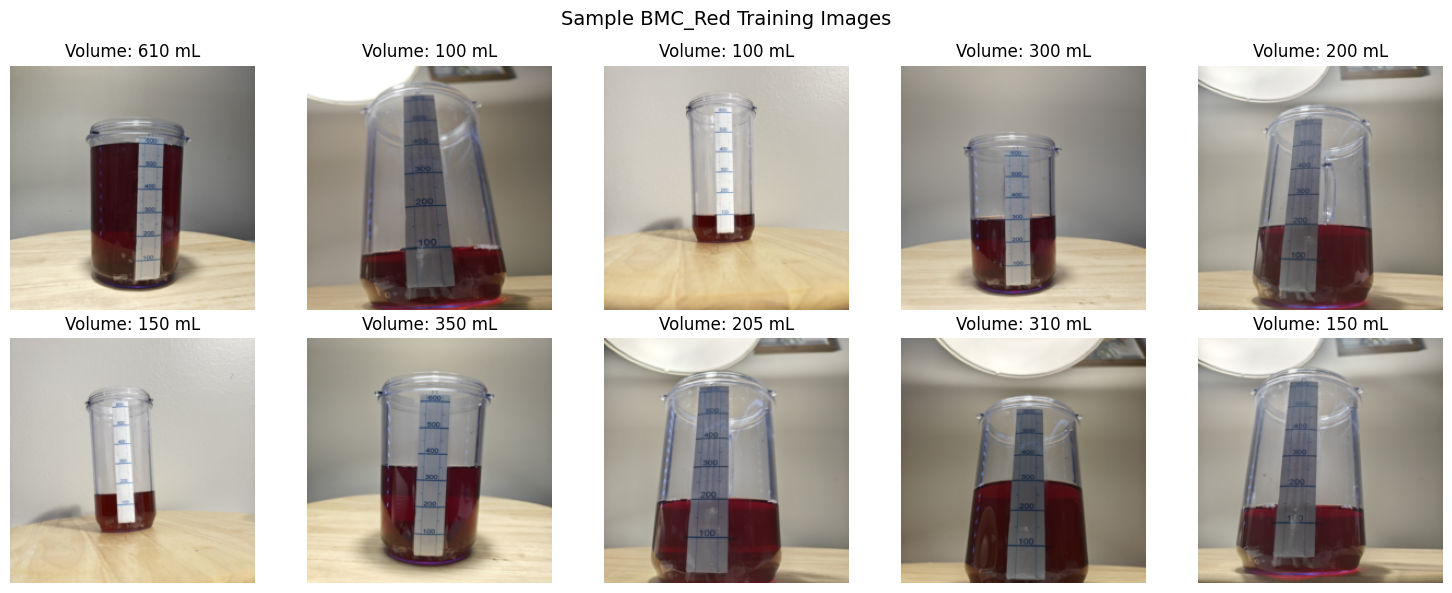

In [6]:
# ============================================================
# CELL 6: VISUALIZE SAMPLE IMAGES
# ============================================================

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
sample_indices = np.random.choice(len(X_train), 10, replace=False)

for i, idx in enumerate(sample_indices):
    ax = axes[i // 5, i % 5]
    ax.imshow(X_train[idx])
    ax.set_title(f'Volume: {int(Y_train[idx])} mL')
    ax.axis('off')

plt.suptitle('Sample BMC_Red Training Images', fontsize=14)
plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# CELL 7: SETUP PRETRAINED WEIGHTS
# ============================================================
print("="*60)
print("SETTING UP EFFICIENTNET WEIGHTS")
print("="*60)

# Download correct weights manually (hash mismatch fix)
cache_dir = os.path.expanduser('~/.cache/torch/hub/checkpoints')
os.makedirs(cache_dir, exist_ok=True)
EFFICIENTNET_WEIGHTS_PATH = os.path.join(cache_dir, 'efficientnet_b0.pth')
weights_url = "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth"

if not os.path.exists(EFFICIENTNET_WEIGHTS_PATH):
    print("Downloading EfficientNetB0 pretrained weights...")
    torch.hub.download_url_to_file(weights_url, EFFICIENTNET_WEIGHTS_PATH, hash_prefix=None)
    print("Downloaded successfully!")
else:
    print(f"Using cached weights: {EFFICIENTNET_WEIGHTS_PATH}")

SETTING UP EFFICIENTNET WEIGHTS
Using cached weights: /home/schurakan/.cache/torch/hub/checkpoints/efficientnet_b0.pth


In [8]:
# ============================================================
# CELL 8: MODEL FACTORY
# ============================================================

class EfficientNetRegressor(nn.Module):
    """EfficientNetB0 with configurable hyperparameters for regression."""

    def __init__(self, params):
        super().__init__()
        
        # Extract hyperparameters with defaults
        neurons = int(params.get('neurons', 128))
        dropout = float(params.get('dropout', 0.3))
        freeze_ratio = float(params.get('freeze_ratio', 0.0))
        num_hidden = int(params.get('num_hidden_layers', 1))
        activation = str(params.get('activation', 'relu'))
        
        # Select activation function
        act_fn_map = {
            'relu': nn.ReLU(),
            'elu': nn.ELU(),
            'selu': nn.SELU(),
            'leaky_relu': nn.LeakyReLU(0.1),
            'gelu': nn.GELU(),
        }
        act_fn = act_fn_map.get(activation, nn.ReLU())

        # Load EfficientNetB0 with manual weight loading
        self.backbone = models.efficientnet_b0(weights=None)
        if os.path.exists(EFFICIENTNET_WEIGHTS_PATH):
            state_dict = torch.load(EFFICIENTNET_WEIGHTS_PATH, map_location='cpu')
            self.backbone.load_state_dict(state_dict)
        
        in_features = self.backbone.classifier[1].in_features
        self.backbone.classifier = nn.Identity()  # Remove classifier

        # Freeze layers based on freeze_ratio
        if freeze_ratio > 0:
            all_params = list(self.backbone.parameters())
            freeze_point = int(len(all_params) * freeze_ratio)
            for i, param in enumerate(all_params):
                param.requires_grad = (i >= freeze_point)
        else:
            for param in self.backbone.parameters():
                param.requires_grad = True

        # Build regression head
        layers = []
        current_features = in_features

        for i in range(num_hidden):
            layers.append(nn.Dropout(dropout))
            layers.append(nn.Linear(current_features, neurons))
            layers.append(copy.deepcopy(act_fn))
            current_features = neurons

        # Final dropout and output
        layers.append(nn.Dropout(dropout / 2))
        layers.append(nn.Linear(current_features, 1))

        self.head = nn.Sequential(*layers)

    def forward(self, x):
        features = self.backbone(x)
        return self.head(features).squeeze(-1)


print("EfficientNet Model Factory defined.")

EfficientNet Model Factory defined.


# Part 1: Train Baseline EfficientNetB0 Model

First, we train a baseline model to:
1. Establish performance benchmark
2. Find good starting hyperparameters for ES

In [9]:
# ============================================================
# CELL 9: BASELINE HYPERPARAMETERS
# ============================================================

# These are reasonable starting hyperparameters
BASELINE_PARAMS = {
    'neurons': 128,
    'dropout': 0.3,
    'learning_rate': 5e-4,
    'batch_size': 16,
    'freeze_ratio': 0.0,  # All layers trainable
    'num_hidden_layers': 1,
    'activation': 'relu'
}

print("Baseline Hyperparameters:")
for name, value in BASELINE_PARAMS.items():
    if name == 'learning_rate':
        print(f"  {name}: {value:.2e}")
    else:
        print(f"  {name}: {value}")

Baseline Hyperparameters:
  neurons: 128
  dropout: 0.3
  learning_rate: 5.00e-04
  batch_size: 16
  freeze_ratio: 0.0
  num_hidden_layers: 1
  activation: relu


In [10]:
# ============================================================
# CELL 10: TRAINING FUNCTION
# ============================================================

def train_model(params, X_train, Y_train, X_val, Y_val, 
                max_epochs=50, patience=10, verbose=True, return_model=False):
    """
    Train a model with given hyperparameters.
    
    Args:
        params: Dictionary of hyperparameters
        X_train, Y_train: Training data (numpy arrays, HWC format)
        X_val, Y_val: Validation data
        max_epochs: Maximum training epochs
        patience: Early stopping patience
        verbose: Print training progress
        return_model: If True, return the trained model
        
    Returns:
        best_val_mae: Best validation MAE achieved
        best_epoch: Epoch where best MAE was achieved
        model (optional): Trained model if return_model=True
    """
    try:
        # Convert to PyTorch tensors (channels-first)
        X_train_t = torch.tensor(X_train.transpose(0, 3, 1, 2), dtype=torch.float32)
        X_val_t = torch.tensor(X_val.transpose(0, 3, 1, 2), dtype=torch.float32)
        Y_train_t = torch.tensor(Y_train, dtype=torch.float32).unsqueeze(1)
        Y_val_t = torch.tensor(Y_val, dtype=torch.float32).unsqueeze(1)
        
        # Create data loaders
        batch_size = int(params.get('batch_size', 16))
        train_dataset = TensorDataset(X_train_t, Y_train_t)
        val_dataset = TensorDataset(X_val_t, Y_val_t)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        
        # Create model
        model = EfficientNetRegressor(params).to(device)
        
        # Setup optimizer and criterion
        lr = float(params.get('learning_rate', 1e-4))
        criterion = nn.L1Loss()  # MAE
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5, verbose=False
        )
        
        # Training loop
        best_mae = float('inf')
        best_epoch = 0
        best_state = None
        patience_counter = 0
        
        for epoch in range(max_epochs):
            # Training
            model.train()
            train_loss = 0
            for X_batch, Y_batch in train_loader:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                optimizer.zero_grad()
                outputs = model(X_batch)
                loss = criterion(outputs, Y_batch.squeeze())
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * X_batch.size(0)
            
            train_mae = train_loss / len(train_dataset)
            
            # Validation
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for X_batch, Y_batch in val_loader:
                    X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                    outputs = model(X_batch)
                    val_loss += criterion(outputs, Y_batch.squeeze()).item() * X_batch.size(0)
            val_mae = val_loss / len(val_dataset)
            
            scheduler.step(val_mae)
            current_lr = optimizer.param_groups[0]['lr']
            
            if val_mae < best_mae:
                best_mae = val_mae
                best_epoch = epoch + 1
                best_state = copy.deepcopy(model.state_dict())
                patience_counter = 0
                if verbose:
                    print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e} *BEST*")
            else:
                patience_counter += 1
                if verbose and (epoch + 1) % 10 == 0:
                    print(f"Epoch {epoch+1:3d}: Train MAE={train_mae:.2f}, Val MAE={val_mae:.2f}, LR={current_lr:.2e}")
            
            if patience_counter >= patience:
                if verbose:
                    print(f"Early stopping at epoch {epoch+1}")
                break
        
        # Load best state
        if best_state is not None:
            model.load_state_dict(best_state)
        
        if return_model:
            return best_mae, best_epoch, model
        else:
            # Cleanup
            del model, optimizer, scheduler
            gc.collect()
            torch.cuda.empty_cache()
            return best_mae, best_epoch
        
    except Exception as e:
        print(f"Error during training: {e}")
        gc.collect()
        torch.cuda.empty_cache()
        if return_model:
            return float('inf'), 0, None
        return float('inf'), 0


print("Training function defined.")

Training function defined.


In [11]:
# ============================================================
# CELL 11: TRAIN BASELINE MODEL
# ============================================================
print("="*60)
print("TRAINING BASELINE MODEL")
print("="*60)

baseline_start = time.time()

baseline_val_mae, baseline_best_epoch, baseline_model = train_model(
    BASELINE_PARAMS, 
    X_train, Y_train, 
    X_val, Y_val,
    max_epochs=BASELINE_EPOCHS,
    patience=BASELINE_PATIENCE,
    verbose=True,
    return_model=True
)

baseline_time = time.time() - baseline_start
print(f"\nBaseline training completed in {baseline_time/60:.2f} minutes")
print(f"Best Validation MAE: {baseline_val_mae:.4f} mL (epoch {baseline_best_epoch})")

# Save baseline model
torch.save(baseline_model.state_dict(), MODEL_SAVE_PATH)
print(f"Baseline model saved to: {MODEL_SAVE_PATH}")

TRAINING BASELINE MODEL
Epoch   1: Train MAE=318.73, Val MAE=284.55, LR=5.00e-04 *BEST*
Epoch   2: Train MAE=224.75, Val MAE=161.77, LR=5.00e-04 *BEST*
Epoch   3: Train MAE=107.42, Val MAE=51.40, LR=5.00e-04 *BEST*
Epoch   4: Train MAE=55.49, Val MAE=17.75, LR=5.00e-04 *BEST*
Epoch   6: Train MAE=32.94, Val MAE=14.94, LR=5.00e-04 *BEST*
Epoch   8: Train MAE=29.46, Val MAE=11.88, LR=5.00e-04 *BEST*
Epoch  10: Train MAE=29.21, Val MAE=22.06, LR=5.00e-04
Epoch  16: Train MAE=24.76, Val MAE=10.19, LR=2.50e-04 *BEST*
Epoch  18: Train MAE=19.43, Val MAE=7.53, LR=2.50e-04 *BEST*
Epoch  20: Train MAE=19.77, Val MAE=11.15, LR=2.50e-04
Epoch  25: Train MAE=18.06, Val MAE=7.27, LR=1.25e-04 *BEST*
Epoch  26: Train MAE=18.49, Val MAE=6.08, LR=1.25e-04 *BEST*
Epoch  30: Train MAE=17.04, Val MAE=7.57, LR=1.25e-04
Epoch  31: Train MAE=17.57, Val MAE=5.45, LR=1.25e-04 *BEST*
Epoch  39: Train MAE=16.74, Val MAE=4.37, LR=6.25e-05 *BEST*
Epoch  40: Train MAE=15.93, Val MAE=5.52, LR=6.25e-05
Epoch  50: Tra

In [12]:
# ============================================================
# CELL 12: EVALUATE BASELINE ON TEST SET
# ============================================================
print("="*60)
print("EVALUATING BASELINE ON TEST SET")
print("="*60)

# Convert test data
X_test_t = torch.tensor(X_test.transpose(0, 3, 1, 2), dtype=torch.float32)
Y_test_t = torch.tensor(Y_test, dtype=torch.float32)
test_dataset = TensorDataset(X_test_t, Y_test_t)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Evaluate
baseline_model.eval()
baseline_predictions = []
baseline_actuals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = baseline_model(images)
        baseline_predictions.extend(outputs.cpu().numpy())
        baseline_actuals.extend(labels.numpy())

baseline_predictions = np.array(baseline_predictions)
baseline_actuals = np.array(baseline_actuals)

baseline_test_mae = np.mean(np.abs(baseline_actuals - baseline_predictions))
baseline_accuracies = 100 * (1 - np.abs(baseline_actuals - baseline_predictions) / baseline_actuals)
baseline_avg_accuracy = np.mean(baseline_accuracies)

print(f"\nBaseline Test Results:")
print(f"  Test MAE: {baseline_test_mae:.4f} mL")
print(f"  Average Accuracy: {baseline_avg_accuracy:.2f}%")
print(f"  Samples >95% accuracy: {np.sum(baseline_accuracies > 95)}/{len(baseline_accuracies)}")
print(f"  Samples >90% accuracy: {np.sum(baseline_accuracies > 90)}/{len(baseline_accuracies)}")

# Clean up baseline model from GPU
del baseline_model
gc.collect()
torch.cuda.empty_cache()

EVALUATING BASELINE ON TEST SET

Baseline Test Results:
  Test MAE: 10.3671 mL
  Average Accuracy: 94.39%
  Samples >95% accuracy: 86/107
  Samples >90% accuracy: 90/107


# Part 2: ES(1+1) Hyperparameter Optimization

Now we apply **Evolution Strategy (1+1)** with the **1/5 success rule** to optimize hyperparameters.

**Key improvements:**
- Uses validation set (NOT test set) for ES evaluation
- No early termination - runs full generations
- Starts from baseline parameters
- Wider search ranges for more exploration

In [13]:
# ============================================================
# CELL 13: ES(1+1) CONFIGURATION
# ============================================================
print("="*60)
print("ES(1+1) WITH 1/5 SUCCESS RULE - CONFIGURATION")
print("="*60)

# ES(1+1) configuration
ES_CONFIG = {
    'max_generations': 50,       # Run full optimization
    'stagnation_limit': 20,      # Stop if no improvement for this many generations
    'success_window': 10,        # Window for computing success rate
    'epochs_per_eval': 25,       # Training epochs per ES evaluation
    'patience_per_eval': 8,      # Early stopping patience per evaluation
    'c': 0.82,                   # Adaptation factor for 1/5 rule
    'step_scale_min': 0.1,       # Minimum step scale
    'step_scale_max': 3.0,       # Maximum step scale
}

# Initial step sizes for mutations (wider ranges for exploration)
INITIAL_STEP_SIZES = {
    'neurons': 40.0,             # +/- 40 neurons
    'dropout': 0.08,             # +/- 0.08 dropout
    'learning_rate': 0.4,        # log scale - wider range
    'freeze_ratio': 0.08,        # +/- 0.08 freeze ratio
}

# Hyperparameter bounds (wider than original)
PARAM_BOUNDS = {
    'neurons': (32, 512),
    'dropout': (0.05, 0.6),
    'learning_rate': (1e-5, 1e-2),  # Will use log scale
    'freeze_ratio': (0.0, 0.7),
    'batch_size': [8, 16, 24, 32],
    'num_hidden_layers': [1, 2, 3],
    'activation': ['relu', 'elu', 'leaky_relu', 'gelu'],
}

print(f"\nES Configuration:")
for name, value in ES_CONFIG.items():
    print(f"  {name}: {value}")

print(f"\nInitial Step Sizes:")
for name, value in INITIAL_STEP_SIZES.items():
    print(f"  {name}: {value}")

print(f"\nParameter Bounds:")
for name, value in PARAM_BOUNDS.items():
    print(f"  {name}: {value}")

ES(1+1) WITH 1/5 SUCCESS RULE - CONFIGURATION

ES Configuration:
  max_generations: 50
  stagnation_limit: 20
  success_window: 10
  epochs_per_eval: 25
  patience_per_eval: 8
  c: 0.82
  step_scale_min: 0.1
  step_scale_max: 3.0

Initial Step Sizes:
  neurons: 40.0
  dropout: 0.08
  learning_rate: 0.4
  freeze_ratio: 0.08

Parameter Bounds:
  neurons: (32, 512)
  dropout: (0.05, 0.6)
  learning_rate: (1e-05, 0.01)
  freeze_ratio: (0.0, 0.7)
  batch_size: [8, 16, 24, 32]
  num_hidden_layers: [1, 2, 3]
  activation: ['relu', 'elu', 'leaky_relu', 'gelu']


In [14]:
# ============================================================
# CELL 14: ES HELPER FUNCTIONS
# ============================================================

def mutate_params(parent_params, step_sizes, bounds=PARAM_BOUNDS):
    """
    Mutate hyperparameters using Gaussian perturbation.
    
    Continuous params: Gaussian mutation
    Discrete params: Random selection with probability
    """
    child = copy.deepcopy(parent_params)
    
    # Mutate neurons (hidden layer size) - Gaussian
    child['neurons'] = int(np.clip(
        child['neurons'] + np.random.normal(0, step_sizes['neurons']),
        bounds['neurons'][0], bounds['neurons'][1]
    ))
    
    # Mutate dropout rate - Gaussian
    child['dropout'] = float(np.clip(
        child['dropout'] + np.random.normal(0, step_sizes['dropout']),
        bounds['dropout'][0], bounds['dropout'][1]
    ))
    
    # Mutate learning rate (log-scale) - Gaussian
    log_lr = np.log10(parent_params['learning_rate'])
    log_lr_min = np.log10(bounds['learning_rate'][0])
    log_lr_max = np.log10(bounds['learning_rate'][1])
    log_lr_new = np.clip(log_lr + np.random.normal(0, step_sizes['learning_rate']), log_lr_min, log_lr_max)
    child['learning_rate'] = float(10 ** log_lr_new)
    
    # Mutate freeze_ratio - Gaussian
    child['freeze_ratio'] = float(np.clip(
        child['freeze_ratio'] + np.random.normal(0, step_sizes['freeze_ratio']),
        bounds['freeze_ratio'][0], bounds['freeze_ratio'][1]
    ))
    
    # Occasionally mutate batch size (25% chance)
    if np.random.random() < 0.25:
        child['batch_size'] = int(np.random.choice(bounds['batch_size']))
    
    # Occasionally mutate num_hidden_layers (20% chance)
    if np.random.random() < 0.20:
        child['num_hidden_layers'] = int(np.random.choice(bounds['num_hidden_layers']))
    
    # Occasionally mutate activation (15% chance)
    if np.random.random() < 0.15:
        child['activation'] = str(np.random.choice(bounds['activation']))
    
    return child


def apply_one_fifth_rule(success_rate, step_sizes, c=0.82, 
                         scale_min=0.1, scale_max=3.0, initial_steps=INITIAL_STEP_SIZES):
    """
    Apply the 1/5 success rule to adapt step sizes.
    
    If success_rate > 1/5 (0.2): increase step sizes (explore more)
    If success_rate < 1/5 (0.2): decrease step sizes (exploit current region)
    
    Returns updated step sizes with bounds checking.
    """
    if success_rate > 0.2:
        factor = 1.0 / c  # Increase step sizes (~1.22)
    else:
        factor = c  # Decrease step sizes
    
    new_steps = {}
    for key, val in step_sizes.items():
        new_val = val * factor
        # Bound step sizes relative to initial
        min_step = initial_steps[key] * scale_min
        max_step = initial_steps[key] * scale_max
        new_steps[key] = np.clip(new_val, min_step, max_step)
    
    return new_steps


def format_params(params):
    """Format parameters for display."""
    return (f"neurons={params['neurons']}, dropout={params['dropout']:.3f}, "
            f"lr={params['learning_rate']:.2e}, freeze={params['freeze_ratio']:.2f}, "
            f"batch={params['batch_size']}, layers={params['num_hidden_layers']}, "
            f"act={params['activation']}")


print("ES helper functions defined:")
print("  - mutate_params(): Apply Gaussian mutation with bounds")
print("  - apply_one_fifth_rule(): Adapt step sizes with bounds")
print("  - format_params(): Format parameters for display")

ES helper functions defined:
  - mutate_params(): Apply Gaussian mutation with bounds
  - apply_one_fifth_rule(): Adapt step sizes with bounds
  - format_params(): Format parameters for display


In [15]:
# ============================================================
# CELL 15: ES(1+1) MAIN OPTIMIZATION LOOP
# ============================================================
print("="*70)
print("ES(1+1) OPTIMIZATION WITH 1/5 SUCCESS RULE")
print("="*70)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"\nNOTE: Using VALIDATION set for ES evaluation (test set held out)")

ES_START_TIME = time.time()

# Initialize step sizes
step_sizes = INITIAL_STEP_SIZES.copy()

# Initialize parent with BASELINE parameters (the key improvement!)
parent = copy.deepcopy(BASELINE_PARAMS)
print(f"\nStarting from baseline parameters:")
print(f"  {format_params(parent)}")

# Evaluate parent on validation set
print(f"\nEvaluating initial parent on validation set...")
parent_mae, parent_epoch = train_model(
    parent, X_train, Y_train, X_val, Y_val,
    max_epochs=ES_CONFIG['epochs_per_eval'],
    patience=ES_CONFIG['patience_per_eval'],
    verbose=False
)
print(f"Parent Validation MAE: {parent_mae:.4f} (best epoch: {parent_epoch})")

# Track best solution
best_params = copy.deepcopy(parent)
best_mae = parent_mae

# History tracking
es_history = {
    'generation': [0],
    'parent_mae': [parent_mae],
    'child_mae': [parent_mae],
    'best_mae': [best_mae],
    'success_rate': [0.0],
    'step_scale': [1.0],
    'params_history': [copy.deepcopy(parent)]
}

# Success tracking for 1/5 rule
success_history = []
stagnation_counter = 0

print(f"\n{'Gen':>4} | {'Parent MAE':>10} | {'Child MAE':>10} | {'Best MAE':>10} | {'Success%':>8} | {'Step':>6} | {'Status':>10}")
print("-" * 80)

for gen in range(1, ES_CONFIG['max_generations'] + 1):
    gen_start = time.time()
    
    # Mutate parent to create child
    child = mutate_params(parent, step_sizes)
    
    # Evaluate child on VALIDATION set (not test!)
    child_mae, child_epoch = train_model(
        child, X_train, Y_train, X_val, Y_val,
        max_epochs=ES_CONFIG['epochs_per_eval'],
        patience=ES_CONFIG['patience_per_eval'],
        verbose=False
    )
    
    # Selection: (1+1) - child replaces parent if better
    if child_mae < parent_mae:
        parent = copy.deepcopy(child)
        parent_mae = child_mae
        success = True
        status = "*BETTER*"
        stagnation_counter = 0
        
        # Track global best
        if child_mae < best_mae:
            best_mae = child_mae
            best_params = copy.deepcopy(child)
            status = "**BEST**"
    else:
        success = False
        status = ""
        stagnation_counter += 1
    
    success_history.append(success)
    
    # Compute success rate over window
    window = ES_CONFIG['success_window']
    if len(success_history) >= window:
        success_rate = sum(success_history[-window:]) / window
    else:
        success_rate = sum(success_history) / len(success_history)
    
    # Apply 1/5 rule every 'window' generations
    current_scale = step_sizes['neurons'] / INITIAL_STEP_SIZES['neurons']
    if gen % window == 0:
        step_sizes = apply_one_fifth_rule(
            success_rate, step_sizes, ES_CONFIG['c'],
            ES_CONFIG['step_scale_min'], ES_CONFIG['step_scale_max']
        )
        new_scale = step_sizes['neurons'] / INITIAL_STEP_SIZES['neurons']
        if abs(new_scale - current_scale) > 0.01:
            print(f"  [1/5 Rule] Success rate: {success_rate:.1%}, Step scale: {current_scale:.2f} -> {new_scale:.2f}")
        current_scale = new_scale
    
    # Record history
    es_history['generation'].append(gen)
    es_history['parent_mae'].append(parent_mae)
    es_history['child_mae'].append(child_mae)
    es_history['best_mae'].append(best_mae)
    es_history['success_rate'].append(success_rate)
    es_history['step_scale'].append(current_scale)
    es_history['params_history'].append(copy.deepcopy(child))
    
    gen_time = time.time() - gen_start
    print(f"{gen:4d} | {parent_mae:10.4f} | {child_mae:10.4f} | {best_mae:10.4f} | {success_rate:7.1%} | {current_scale:6.2f} | {status:>10}")
    
    # Check stagnation
    if stagnation_counter >= ES_CONFIG['stagnation_limit']:
        print(f"\nStopping: No improvement for {ES_CONFIG['stagnation_limit']} generations")
        break

es_time = time.time() - ES_START_TIME
print("-" * 80)
print(f"\nES Optimization completed in {es_time/60:.2f} minutes")
print(f"Best Validation MAE: {best_mae:.4f} mL")
print(f"Improvement over baseline: {baseline_val_mae - best_mae:.4f} mL ({100*(baseline_val_mae - best_mae)/baseline_val_mae:.1f}%)")

ES(1+1) OPTIMIZATION WITH 1/5 SUCCESS RULE
Start time: 2025-12-03 12:33:23

NOTE: Using VALIDATION set for ES evaluation (test set held out)

Starting from baseline parameters:
  neurons=128, dropout=0.300, lr=5.00e-04, freeze=0.00, batch=16, layers=1, act=relu

Evaluating initial parent on validation set...
Parent Validation MAE: 8.2142 (best epoch: 18)

 Gen | Parent MAE |  Child MAE |   Best MAE | Success% |   Step |     Status
--------------------------------------------------------------------------------
   1 |     8.2142 |    10.2159 |     8.2142 |    0.0% |   1.00 |           
   2 |     8.0989 |     8.0989 |     8.0989 |   50.0% |   1.00 |   **BEST**
   3 |     8.0989 |    13.4906 |     8.0989 |   33.3% |   1.00 |           
   4 |     8.0989 |     9.0472 |     8.0989 |   25.0% |   1.00 |           
   5 |     8.0989 |   295.8073 |     8.0989 |   20.0% |   1.00 |           
   6 |     8.0989 |   292.9994 |     8.0989 |   16.7% |   1.00 |           
   7 |     7.8187 |     7.81

In [16]:
# ============================================================
# CELL 16: ES OPTIMIZATION RESULTS
# ============================================================
print("="*60)
print("ES(1+1) OPTIMIZATION RESULTS")
print("="*60)

print(f"\n{'='*60}")
print("BEST PARAMETERS FOUND:")
print(f"{'='*60}")
for name, value in best_params.items():
    baseline_val = BASELINE_PARAMS[name]
    if name == 'learning_rate':
        changed = "*" if abs(np.log10(value) - np.log10(baseline_val)) > 0.1 else ""
        print(f"  {name}: {value:.2e} (baseline: {baseline_val:.2e}) {changed}")
    elif name == 'neurons':
        changed = "*" if abs(value - baseline_val) > 10 else ""
        print(f"  {name}: {int(value)} (baseline: {int(baseline_val)}) {changed}")
    elif isinstance(value, float):
        changed = "*" if abs(value - baseline_val) > 0.05 else ""
        print(f"  {name}: {value:.4f} (baseline: {baseline_val:.4f}) {changed}")
    else:
        changed = "*" if value != baseline_val else ""
        print(f"  {name}: {value} (baseline: {baseline_val}) {changed}")

print(f"\n(* = significantly changed from baseline)")

print(f"\n{'='*60}")
print("VALIDATION PERFORMANCE COMPARISON:")
print(f"{'='*60}")
print(f"  Baseline Val MAE: {baseline_val_mae:.4f} mL")
print(f"  Best ES Val MAE:  {best_mae:.4f} mL")
improvement = baseline_val_mae - best_mae
improvement_pct = 100 * improvement / baseline_val_mae if baseline_val_mae > 0 else 0
print(f"  Improvement:      {improvement:.4f} mL ({improvement_pct:.1f}%)")

ES(1+1) OPTIMIZATION RESULTS

BEST PARAMETERS FOUND:
  neurons: 337 (baseline: 128) *
  dropout: 0.2894 (baseline: 0.3000) 
  learning_rate: 5.55e-04 (baseline: 5.00e-04) 
  batch_size: 16 (baseline: 16) 
  freeze_ratio: 0.0000 (baseline: 0.0000) 
  num_hidden_layers: 1 (baseline: 1) 
  activation: elu (baseline: relu) *

(* = significantly changed from baseline)

VALIDATION PERFORMANCE COMPARISON:
  Baseline Val MAE: 4.3661 mL
  Best ES Val MAE:  4.6128 mL
  Improvement:      -0.2467 mL (-5.6%)


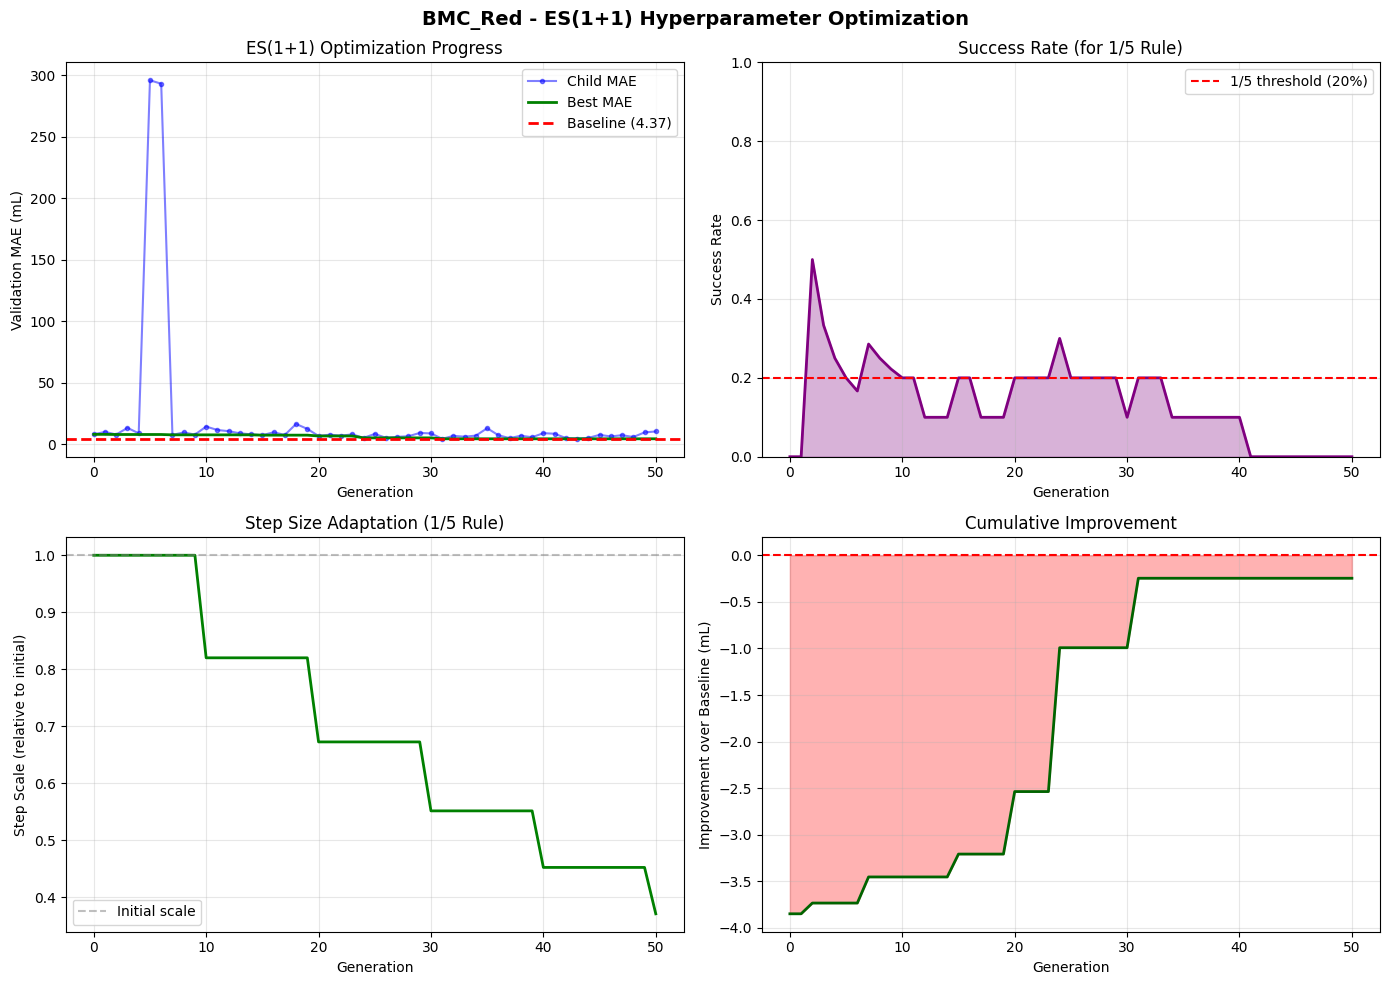


Saved: es_optimization_history.png


In [27]:
# ============================================================
# CELL 17: PLOT ES OPTIMIZATION HISTORY
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

generations = es_history['generation']

# 1. MAE over generations
ax1 = axes[0, 0]
ax1.plot(generations, es_history['child_mae'], 'b-o', markersize=3, alpha=0.5, label='Child MAE')
ax1.plot(generations, es_history['best_mae'], 'g-', linewidth=2, label='Best MAE')
ax1.axhline(y=baseline_val_mae, color='r', linestyle='--', linewidth=2, label=f'Baseline ({baseline_val_mae:.2f})')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Validation MAE (mL)')
ax1.set_title('ES(1+1) Optimization Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Success rate
ax2 = axes[0, 1]
ax2.plot(generations, es_history['success_rate'], 'purple', linewidth=2)
ax2.axhline(y=0.2, color='r', linestyle='--', label='1/5 threshold (20%)')
ax2.fill_between(generations, 0, es_history['success_rate'], alpha=0.3, color='purple')
ax2.set_xlabel('Generation')
ax2.set_ylabel('Success Rate')
ax2.set_title('Success Rate (for 1/5 Rule)')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Step size adaptation
ax3 = axes[1, 0]
ax3.plot(generations, es_history['step_scale'], 'green', linewidth=2)
ax3.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5, label='Initial scale')
ax3.set_xlabel('Generation')
ax3.set_ylabel('Step Scale (relative to initial)')
ax3.set_title('Step Size Adaptation (1/5 Rule)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Improvement over baseline
ax4 = axes[1, 1]
improvements = [baseline_val_mae - m for m in es_history['best_mae']]
ax4.fill_between(generations, 0, improvements, alpha=0.3, color='green', where=[i >= 0 for i in improvements])
ax4.fill_between(generations, 0, improvements, alpha=0.3, color='red', where=[i < 0 for i in improvements])
ax4.plot(generations, improvements, 'darkgreen', linewidth=2)
ax4.axhline(y=0, color='r', linestyle='--')
ax4.set_xlabel('Generation')
ax4.set_ylabel('Improvement over Baseline (mL)')
ax4.set_title('Cumulative Improvement')
ax4.grid(True, alpha=0.3)

plt.suptitle('BMC_Red - ES(1+1) Hyperparameter Optimization', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'es_optimization_history.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"\nSaved: es_optimization_history.png")

In [18]:
# ============================================================
# CELL 18: TRAIN FINAL MODEL WITH BEST ES PARAMETERS
# ============================================================
print("="*60)
print("FINAL TRAINING WITH BEST ES PARAMETERS")
print("="*60)

print("\nBest parameters from ES:")
print(f"  {format_params(best_params)}")

# Train on FULL training data (train + val) for final model
print(f"\nTraining final model on FULL training data ({len(X_train_full)} images)...")
print(f"Training for {BASELINE_EPOCHS} epochs...")

final_start = time.time()

# For final training, use full training data and validate on test set
final_mae, final_epoch, final_model = train_model(
    best_params,
    X_train_full, Y_train_full,  # Full training data
    X_test, Y_test,               # Test set for validation (only for final training)
    max_epochs=BASELINE_EPOCHS,
    patience=BASELINE_PATIENCE,
    verbose=True,
    return_model=True
)

final_time = time.time() - final_start
print(f"\nFinal training completed in {final_time/60:.2f} minutes")
print(f"Best epoch: {final_epoch}")

# Save final model
torch.save(final_model.state_dict(), ES_MODEL_SAVE_PATH)
print(f"Model saved to: {ES_MODEL_SAVE_PATH}")

FINAL TRAINING WITH BEST ES PARAMETERS

Best parameters from ES:
  neurons=337, dropout=0.289, lr=5.55e-04, freeze=0.00, batch=16, layers=1, act=elu

Training final model on FULL training data (794 images)...
Training for 50 epochs...
Epoch   1: Train MAE=272.59, Val MAE=92.19, LR=5.55e-04 *BEST*
Epoch   2: Train MAE=71.86, Val MAE=59.98, LR=5.55e-04 *BEST*
Epoch   3: Train MAE=43.45, Val MAE=23.87, LR=5.55e-04 *BEST*
Epoch   6: Train MAE=30.31, Val MAE=20.95, LR=5.55e-04 *BEST*
Epoch   9: Train MAE=17.89, Val MAE=15.60, LR=5.55e-04 *BEST*
Epoch  10: Train MAE=17.69, Val MAE=34.08, LR=5.55e-04
Epoch  18: Train MAE=13.11, Val MAE=13.30, LR=2.77e-04 *BEST*
Epoch  20: Train MAE=13.82, Val MAE=13.33, LR=2.77e-04
Epoch  23: Train MAE=12.68, Val MAE=11.79, LR=2.77e-04 *BEST*
Epoch  26: Train MAE=12.62, Val MAE=9.53, LR=2.77e-04 *BEST*
Epoch  30: Train MAE=12.33, Val MAE=14.27, LR=2.77e-04
Epoch  40: Train MAE=10.43, Val MAE=11.23, LR=6.93e-05
Early stopping at epoch 41

Final training comple

In [19]:
# ============================================================
# CELL 19: FINAL EVALUATION ON TEST SET
# ============================================================
print("="*60)
print("FINAL EVALUATION ON TEST SET")
print("="*60)

# Evaluate final ES-optimized model
final_model.eval()
es_predictions = []
es_actuals = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = final_model(images)
        es_predictions.extend(outputs.cpu().numpy())
        es_actuals.extend(labels.numpy())

es_predictions = np.array(es_predictions)
es_actuals = np.array(es_actuals)

es_test_mae = np.mean(np.abs(es_actuals - es_predictions))
es_accuracies = 100 * (1 - np.abs(es_actuals - es_predictions) / es_actuals)
es_avg_accuracy = np.mean(es_accuracies)

print(f"\nES Optimized Model - Test Results:")
print(f"  Test MAE: {es_test_mae:.4f} mL")
print(f"  Average Accuracy: {es_avg_accuracy:.2f}%")
print(f"  Samples >95% accuracy: {np.sum(es_accuracies > 95)}/{len(es_accuracies)} ({100*np.sum(es_accuracies > 95)/len(es_accuracies):.1f}%)")
print(f"  Samples >90% accuracy: {np.sum(es_accuracies > 90)}/{len(es_accuracies)} ({100*np.sum(es_accuracies > 90)/len(es_accuracies):.1f}%)")

print(f"\n{'='*60}")
print("COMPARISON: BASELINE vs ES OPTIMIZED (on Test Set)")
print(f"{'='*60}")
print(f"  Baseline Test MAE:     {baseline_test_mae:.4f} mL ({baseline_avg_accuracy:.2f}% accuracy)")
print(f"  ES Optimized Test MAE: {es_test_mae:.4f} mL ({es_avg_accuracy:.2f}% accuracy)")
test_improvement = baseline_test_mae - es_test_mae
test_improvement_pct = 100 * test_improvement / baseline_test_mae if baseline_test_mae > 0 else 0
print(f"  Improvement:           {test_improvement:.4f} mL ({test_improvement_pct:.1f}%)")

FINAL EVALUATION ON TEST SET

ES Optimized Model - Test Results:
  Test MAE: 9.5336 mL
  Average Accuracy: 95.13%
  Samples >95% accuracy: 79/107 (73.8%)
  Samples >90% accuracy: 90/107 (84.1%)

COMPARISON: BASELINE vs ES OPTIMIZED (on Test Set)
  Baseline Test MAE:     10.3671 mL (94.39% accuracy)
  ES Optimized Test MAE: 9.5336 mL (95.13% accuracy)
  Improvement:           0.8336 mL (8.0%)


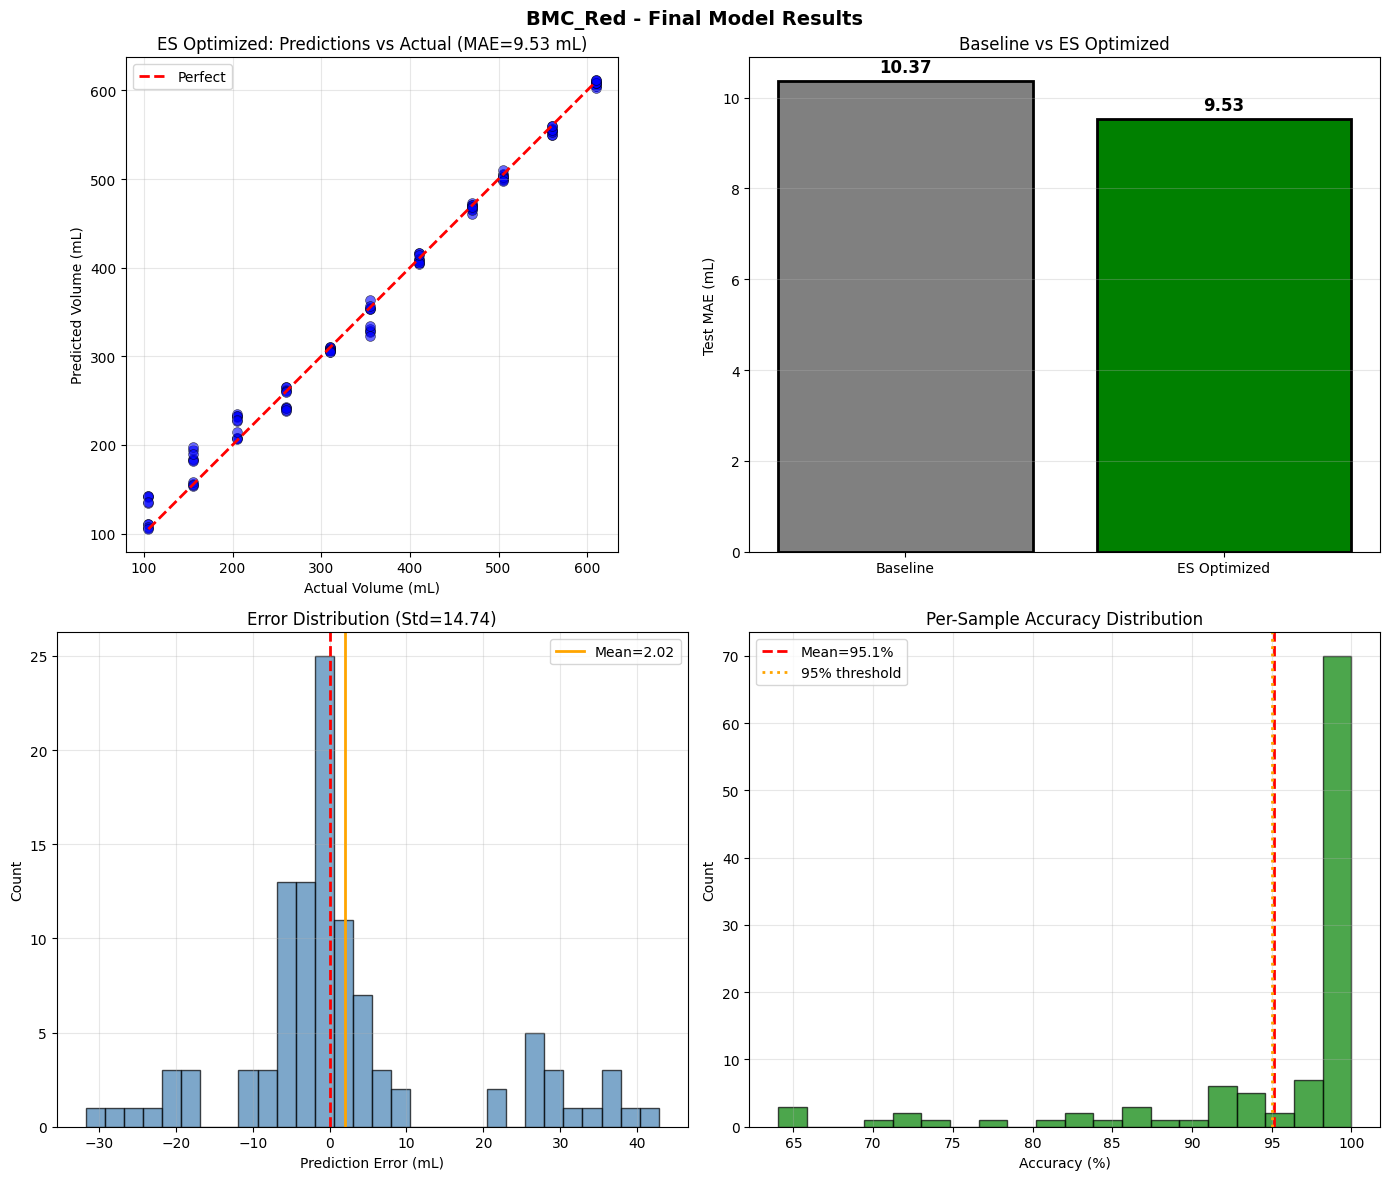

Saved: es_final_results.png


In [20]:
# ============================================================
# CELL 20: VISUALIZATION - PREDICTIONS VS ACTUAL
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Predictions vs Actual
ax1 = axes[0, 0]
ax1.scatter(es_actuals, es_predictions, alpha=0.6, s=50, c='blue', edgecolors='black', linewidth=0.5)
ax1.plot([es_actuals.min(), es_actuals.max()], [es_actuals.min(), es_actuals.max()], 'r--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Volume (mL)')
ax1.set_ylabel('Predicted Volume (mL)')
ax1.set_title(f'ES Optimized: Predictions vs Actual (MAE={es_test_mae:.2f} mL)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# 2. Compare Baseline vs ES
ax2 = axes[0, 1]
x_pos = [0, 1]
maes = [baseline_test_mae, es_test_mae]
colors = ['gray', 'green' if es_test_mae < baseline_test_mae else 'red']
bars = ax2.bar(x_pos, maes, color=colors, edgecolor='black', linewidth=2)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Baseline', 'ES Optimized'])
ax2.set_ylabel('Test MAE (mL)')
ax2.set_title('Baseline vs ES Optimized')
for bar, mae in zip(bars, maes):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, f'{mae:.2f}', 
             ha='center', va='bottom', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. Error Distribution
ax3 = axes[1, 0]
errors = es_predictions - es_actuals
ax3.hist(errors, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
ax3.axvline(x=0, color='r', linestyle='--', linewidth=2)
ax3.axvline(x=np.mean(errors), color='orange', linestyle='-', linewidth=2, label=f'Mean={np.mean(errors):.2f}')
ax3.set_xlabel('Prediction Error (mL)')
ax3.set_ylabel('Count')
ax3.set_title(f'Error Distribution (Std={np.std(errors):.2f})')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Accuracy Distribution
ax4 = axes[1, 1]
ax4.hist(es_accuracies, bins=20, color='green', edgecolor='black', alpha=0.7)
ax4.axvline(x=es_avg_accuracy, color='r', linestyle='--', linewidth=2, label=f'Mean={es_avg_accuracy:.1f}%')
ax4.axvline(x=95, color='orange', linestyle=':', linewidth=2, label='95% threshold')
ax4.set_xlabel('Accuracy (%)')
ax4.set_ylabel('Count')
ax4.set_title('Per-Sample Accuracy Distribution')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.suptitle('BMC_Red - Final Model Results', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'es_final_results.png'), dpi=300, bbox_inches='tight')
plt.show()
print(f"Saved: es_final_results.png")

In [21]:
# ============================================================
# CELL 21: SAMPLE PREDICTIONS
# ============================================================

sorted_idx = np.argsort(es_accuracies)

print("\n" + "="*60)
print("TOP 10 BEST PREDICTIONS")
print("="*60)
best_10 = sorted_idx[-10:][::-1]
for i, idx in enumerate(best_10):
    print(f"{i+1:2d}. Actual: {es_actuals[idx]:>6.0f} mL, Predicted: {es_predictions[idx]:>7.2f} mL, Accuracy: {es_accuracies[idx]:>6.2f}%")

print("\n" + "="*60)
print("TOP 10 WORST PREDICTIONS")
print("="*60)
worst_10 = sorted_idx[:10]
for i, idx in enumerate(worst_10):
    print(f"{i+1:2d}. Actual: {es_actuals[idx]:>6.0f} mL, Predicted: {es_predictions[idx]:>7.2f} mL, Accuracy: {es_accuracies[idx]:>6.2f}%")


TOP 10 BEST PREDICTIONS
 1. Actual:    310 mL, Predicted:  309.98 mL, Accuracy:  99.99%
 2. Actual:    560 mL, Predicted:  559.95 mL, Accuracy:  99.99%
 3. Actual:    310 mL, Predicted:  309.86 mL, Accuracy:  99.95%
 4. Actual:    470 mL, Predicted:  470.23 mL, Accuracy:  99.95%
 5. Actual:    610 mL, Predicted:  610.37 mL, Accuracy:  99.94%
 6. Actual:    470 mL, Predicted:  470.29 mL, Accuracy:  99.94%
 7. Actual:    560 mL, Predicted:  559.54 mL, Accuracy:  99.92%
 8. Actual:    310 mL, Predicted:  310.25 mL, Accuracy:  99.92%
 9. Actual:    505 mL, Predicted:  504.49 mL, Accuracy:  99.90%
10. Actual:    260 mL, Predicted:  260.26 mL, Accuracy:  99.90%

TOP 10 WORST PREDICTIONS
 1. Actual:    105 mL, Predicted:  142.76 mL, Accuracy:  64.04%
 2. Actual:    105 mL, Predicted:  141.83 mL, Accuracy:  64.92%
 3. Actual:    105 mL, Predicted:  141.29 mL, Accuracy:  65.44%
 4. Actual:    105 mL, Predicted:  135.99 mL, Accuracy:  70.49%
 5. Actual:    105 mL, Predicted:  134.86 mL, Accurac

In [22]:
# ============================================================
# CELL 22: SAVE RESULTS
# ============================================================

# Save all results to JSON
results = {
    'dataset': 'BMC_Red',
    'baseline': {
        'params': BASELINE_PARAMS,
        'val_mae': float(baseline_val_mae),
        'test_mae': float(baseline_test_mae),
        'test_accuracy': float(baseline_avg_accuracy)
    },
    'es_optimized': {
        'params': best_params,
        'val_mae': float(best_mae),
        'test_mae': float(es_test_mae),
        'test_accuracy': float(es_avg_accuracy)
    },
    'improvement': {
        'val_mae_improvement': float(baseline_val_mae - best_mae),
        'val_mae_improvement_pct': float(100 * (baseline_val_mae - best_mae) / baseline_val_mae) if baseline_val_mae > 0 else 0,
        'test_mae_improvement': float(test_improvement),
        'test_mae_improvement_pct': float(test_improvement_pct)
    },
    'es_config': ES_CONFIG,
    'total_generations': len(es_history['generation']) - 1,
    'total_time_minutes': (time.time() - START_TIME) / 60
}

with open(ES_RESULTS_PATH, 'w') as f:
    json.dump(results, f, indent=2)

print(f"Results saved to: {ES_RESULTS_PATH}")

Results saved to: /data1/Siri/MeasuringCup/BMC_Red/Red_code/es_optimization_results.json


In [23]:
# ============================================================
# CELL 23: FINAL SUMMARY
# ============================================================

total_time = time.time() - START_TIME
minutes = int(total_time // 60)
seconds = int(total_time % 60)

print("\n" + "#"*70)
print("#" + " "*68 + "#")
print("#" + "  BMC_Red EFFICIENTNETB0 + ES(1+1) OPTIMIZATION  ".center(68) + "#")
print("#" + " "*68 + "#")
print("#"*70)
print("#" + " "*68 + "#")
print("#" + f"  BASELINE:                                                      ".ljust(68) + "#")
print("#" + f"    Val MAE:  {baseline_val_mae:.4f} mL                                          ".ljust(68) + "#")
print("#" + f"    Test MAE: {baseline_test_mae:.4f} mL ({baseline_avg_accuracy:.2f}% accuracy)              ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#" + f"  ES OPTIMIZED:                                                  ".ljust(68) + "#")
print("#" + f"    Val MAE:  {best_mae:.4f} mL                                          ".ljust(68) + "#")
print("#" + f"    Test MAE: {es_test_mae:.4f} mL ({es_avg_accuracy:.2f}% accuracy)              ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#" + "-"*68 + "#")
print("#" + f"  TEST SET IMPROVEMENT: {test_improvement:.4f} mL ({test_improvement_pct:.1f}%)                    ".ljust(68) + "#")
print("#" + f"  Total Time: {minutes:02d}:{seconds:02d} (mm:ss)                                   ".ljust(68) + "#")
print("#" + " "*68 + "#")
print("#"*70)

if es_test_mae < baseline_test_mae:
    print("\n" + "*"*70)
    print("*" + "  SUCCESS: ES found better hyperparameters!  ".center(68, '*') + "*")
    print("*"*70)
else:
    print("\n" + "="*70)
    print("  Note: Baseline was already near-optimal for this dataset.")
    print("  ES explored alternatives but didn't find significant improvement.")
    print("="*70)

print(f"\nModels saved to:")
print(f"  Baseline:     {MODEL_SAVE_PATH}")
print(f"  ES Optimized: {ES_MODEL_SAVE_PATH}")
print(f"  Results JSON: {ES_RESULTS_PATH}")


######################################################################
#                                                                    #
#           BMC_Red EFFICIENTNETB0 + ES(1+1) OPTIMIZATION            #
#                                                                    #
######################################################################
#                                                                    #
#  BASELINE:                                                         #
#    Val MAE:  4.3661 mL                                             #
#    Test MAE: 10.3671 mL (94.39% accuracy)                          #
#                                                                    #
#  ES OPTIMIZED:                                                     #
#    Val MAE:  4.6128 mL                                             #
#    Test MAE: 9.5336 mL (95.13% accuracy)                           #
#                                                                    #
#----